In [8]:
import preprocessing.preprocessing as pp
import torch
from models import baselines
import numpy as np
import evaluation.evaluation as ev
import training.training as tt
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils.convert import from_networkx

In [2]:
G_load = nx.read_gpickle("saved_data/graph_gt_pickle")
L_load = pp.makeDual(G_load)

In [3]:
L_load_torch = from_networkx(L_load)
class_label_list, node_lab, node_lab_explain =  pp.getLablesForDual(L_load)

# assign the ground truth class information to the torch data obj
L_load_torch.y = torch.tensor(class_label_list)

# extract the number of classes and features for model input
num_feat_dual_comb = L_load_torch.x.shape[1]
num_class_dual_comb = len(np.unique(L_load_torch.y))


/home/laurin/.local/lib/python3.8/site-packages/torch_geometric/utils/convert.py:192: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  data[key] = torch.tensor(value)


In [4]:
splitter = tt.Splitter(L_load_torch,seed = 1234567)

train_mask, test_mask = splitter.split_random()

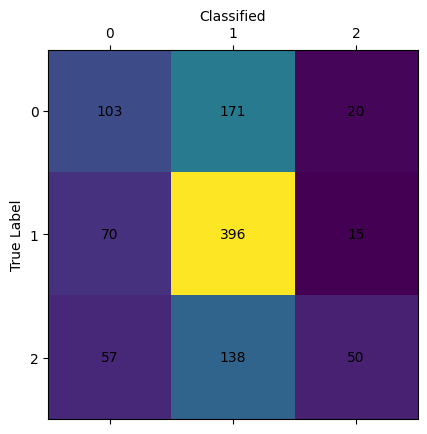

Test Set Accuracy and Balanced Accuracy
0.538235294117647
0.4592355306641021


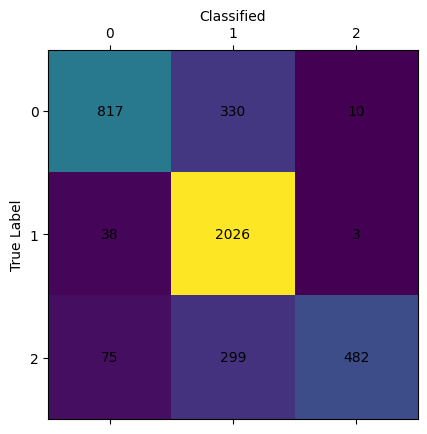

Training Set Accuracy and Balanced Accuracy
0.8149509803921569
0.7497950539390429


In [5]:

clf_rf = baselines.RandomForest(L_load_torch, max_depth = 10)

clf_rf.fit(train_mask)
pred_test = clf_rf.predict(test_mask)
pred_train = clf_rf.predict(train_mask)

ev.plot_confusion_matrix(clf_rf.y[test_mask], pred_test, [0,1,2])
#print(ev.eval_roc_auc(clf_rf.y[test_mask], pred_test))

print("Test Set Accuracy and Balanced Accuracy")
print(accuracy_score(clf_rf.y[test_mask], pred_test))
print(balanced_accuracy_score(clf_rf.y[test_mask], pred_test))


ev.plot_confusion_matrix(clf_rf.y[train_mask], pred_train, [0,1,2])
# extreme overfitting
print("Training Set Accuracy and Balanced Accuracy")
print(accuracy_score(clf_rf.y[train_mask], pred_train))
print(balanced_accuracy_score(clf_rf.y[train_mask], pred_train))



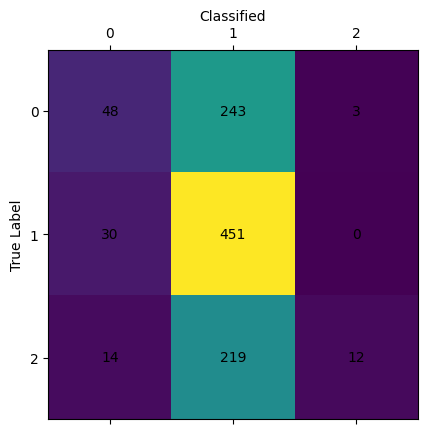

Test Set Accuracy and Balanced Accuracy
0.5009803921568627
0.38329161186304045


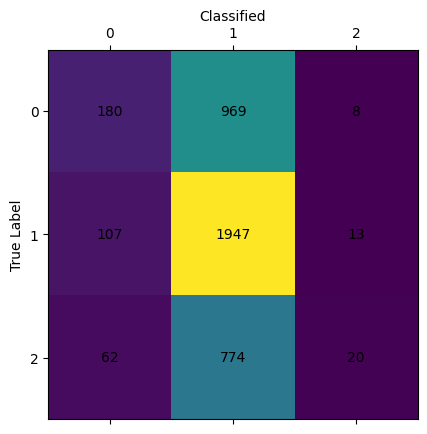

Training Set Accuracy and Balanced Accuracy
0.5262254901960784
0.3736280319676229


In [6]:
clf_svm = baselines.SVM(L_load_torch,C = 1000)

clf_svm.fit(train_mask)
pred_test = clf_svm.predict(test_mask)
pred_train = clf_svm.predict(train_mask)

ev.plot_confusion_matrix(clf_svm.y[test_mask], pred_test, [0,1,2])
#print(ev.eval_roc_auc(clf_svm.y[test_mask], pred_test))

print("Test Set Accuracy and Balanced Accuracy")
print(accuracy_score(clf_svm.y[test_mask], pred_test))
print(balanced_accuracy_score(clf_svm.y[test_mask], pred_test))

ev.plot_confusion_matrix(clf_svm.y[train_mask], pred_train, [0,1,2])
# extreme overfitting
print("Training Set Accuracy and Balanced Accuracy")
print(accuracy_score(clf_svm.y[train_mask], pred_train))
print(balanced_accuracy_score(clf_svm.y[train_mask], pred_train))



/home/laurin/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


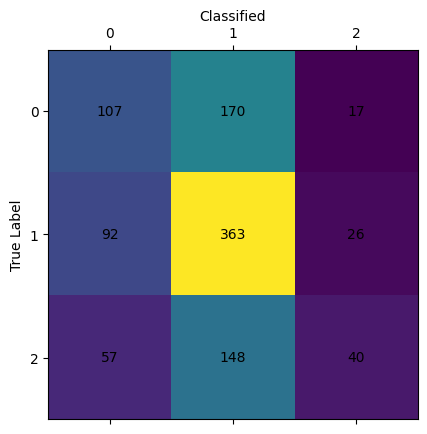

Test Set Accuracy and Balanced Accuracy
0.5
0.4272962130104987


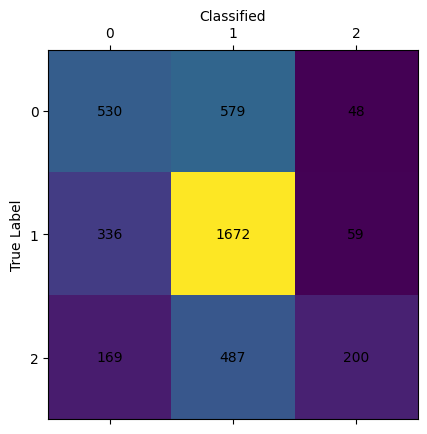

Training Set Accuracy and Balanced Accuracy
0.5887254901960784
0.5002092981483494


In [29]:
clf_mlp = baselines.MLP(L_load_torch, max_iter = 3000, hidden_layer_sizes=(64,32,16),random_state=1234567, learning_rate = "adaptive", learning_rate_init = 0.01, tol =  -1)

clf_mlp.fit(train_mask)
pred_test = clf_mlp.predict(test_mask)
pred_train = clf_mlp.predict(train_mask)

ev.plot_confusion_matrix(clf_mlp.y[test_mask], pred_test, [0,1,2])
#print(ev.eval_roc_auc(clf_mlp.y[test_mask], pred_test))

print("Test Set Accuracy and Balanced Accuracy")
print(accuracy_score(clf_mlp.y[test_mask], pred_test))
print(balanced_accuracy_score(clf_mlp.y[test_mask], pred_test))

ev.plot_confusion_matrix(clf_mlp.y[train_mask], pred_train, [0,1,2])
# extreme overfitting
print("Training Set Accuracy and Balanced Accuracy")
print(accuracy_score(clf_mlp.y[train_mask], pred_train))
print(balanced_accuracy_score(clf_mlp.y[train_mask], pred_train))



17
[0 1 2]


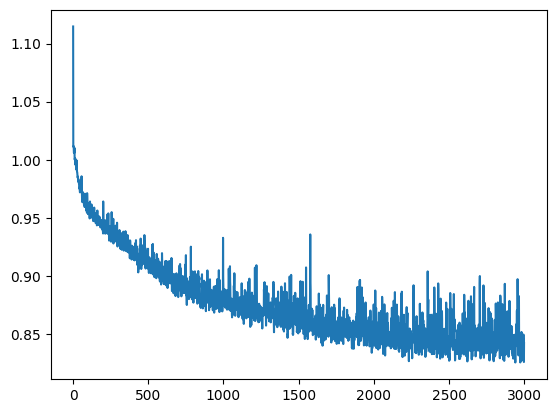

In [30]:
plt.plot(clf_mlp.clf.loss_curve_)
print(clf_mlp.clf.n_features_in_)
print(clf_mlp.clf.classes_)

In [17]:

param_grid_rf = {'max_depth': [2, 4, 8, 16], 'max_features': ["sqrt", "log2"]}
grid_list_rf = list(ParameterGrid(param_grid_rf))

opt_mod = None
max_acc = 0
opt_bal_acc = 0
for i, setting in enumerate(grid_list_rf):
    clf = baselines.RandomForest(L_load_torch,**setting)
    clf.fit(train_mask)
    pred_test = clf.predict(test_mask)
    acc = accuracy_score(clf.y[test_mask], pred_test)
    bal_acc = balanced_accuracy_score(clf.y[test_mask], pred_test)
    if acc > max_acc:
        max_acc = acc
        opt_mod = setting
        opt_bal_acc = bal_acc

#{'max_depth': 8, 'max_features': 'sqrt'}
#0.5803921568627451
#0.4641166464928259
print(opt_mod)
print(max_acc)
print(opt_bal_acc)

{'max_depth': 8, 'max_features': 'sqrt'}
0.5803921568627451
0.4641166464928259


In [18]:
param_grid_svc = {'C': [1, 10, 100, 10000], 'kernel': ["linear", "rbf"]}
grid_list_svc = list(ParameterGrid(param_grid_svc))

opt_mod = None
max_acc = 0
opt_bal_acc = 0
for i, setting in enumerate(grid_list_svc):
    clf = baselines.SVM(L_load_torch,**setting)
    clf.fit(train_mask)
    pred_test = clf.predict(test_mask)
    acc = accuracy_score(clf.y[test_mask], pred_test)
    bal_acc = balanced_accuracy_score(clf.y[test_mask], pred_test)
    if acc > max_acc:
        max_acc = acc
        opt_mod = setting
        opt_bal_acc = bal_acc

# {'C': 10000, 'kernel': 'linear'}
#0.5598039215686275
#0.44860112286408277
print(opt_mod)
print(max_acc)
print(opt_bal_acc)

{'C': 10000, 'kernel': 'linear'}
0.5598039215686275
0.44860112286408277
